Generation 1: Best Fitness = 4162
Generation 2: Best Fitness = 4444
Generation 3: Best Fitness = 3897
Generation 4: Best Fitness = 3151
Generation 5: Best Fitness = 3320
Generation 6: Best Fitness = 3894
Generation 7: Best Fitness = 4674
Generation 8: Best Fitness = 4613
Generation 9: Best Fitness = 4406
Generation 10: Best Fitness = 4159
Generation 11: Best Fitness = 4143
Generation 12: Best Fitness = 4133
Generation 13: Best Fitness = 3615
Generation 14: Best Fitness = 3899
Generation 15: Best Fitness = 3628
Generation 16: Best Fitness = 3895
Generation 17: Best Fitness = 4222
Generation 18: Best Fitness = 4340
Generation 19: Best Fitness = 4274
Generation 20: Best Fitness = 4153
Best Parameters: [0.7950578278341167, 0.6509098761050796, 0.8685863531973065, 0.4618237385954602, 0.33385927607343113, 0.3452863887641166, 0.007984898653161345, 0.006887835173525471, 0.00752665699204515]


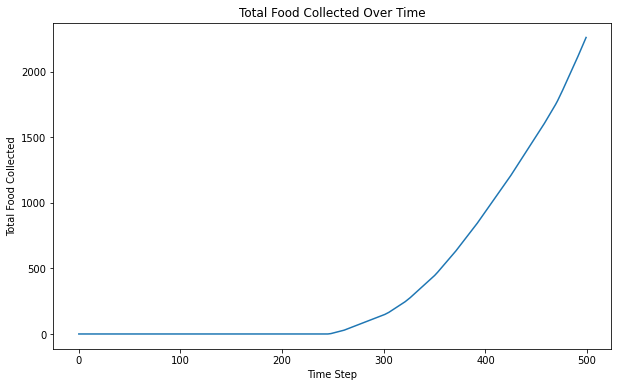

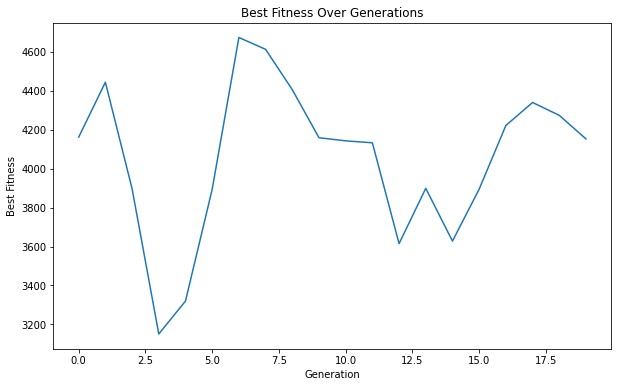

In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Parameters
GRID_SIZE = 50
NEST = (25, 5)
FEEDER_A = (10, 40)
FEEDER_B = (40, 40)
FEEDER_C = (19, 49)
NUM_ANTS = 500
INITIAL_FOOD_A = 100
INITIAL_FOOD_B = 100
INITIAL_FOOD_C = 100
TIME_STEPS = 500

# Genetic Algorithm Parameters
POPULATION_SIZE = 20
NUM_GENERATIONS = 20
MUTATION_RATE = 0.1
TOURNAMENT_SIZE = 5

class Ant:
    def __init__(self, name, position):
        self.name = name
        self.position = position
        self.carrying = False
        self.committed_to = None

    def move(self):
        new_position = (self.position[0] + random.choice([-1, 0, 1]), self.position[1] + random.choice([-1, 0, 1]))
        if 0 <= new_position[0] < GRID_SIZE and 0 <= new_position[1] < GRID_SIZE:
            self.position = new_position

    def return_to_feeder(self):
        if self.committed_to:
            dx = np.sign(self.committed_to.position[0] - self.position[0])
            dy = np.sign(self.committed_to.position[1] - self.position[1])
            new_position = (self.position[0] + dx, self.position[1] + dy)
            if 0 <= new_position[0] < GRID_SIZE and 0 <= new_position[1] < GRID_SIZE:
                self.position = new_position

    def pick_up_food(self, feeder):
        if self.is_near_feeder(feeder) and feeder.food > 0 and not self.carrying:
            feeder.food -= 1
            self.carrying = True

    def drop_food(self):
        if self.position == NEST and self.carrying:
            self.carrying = False

    def is_near_feeder(self, feeder):
        return abs(self.position[0] - feeder.position[0]) <= 1 and abs(self.position[1] - feeder.position[1]) <= 3

    def discover_feeder(self, feeder):
        if self.is_near_feeder(feeder) and random.random() < feeder.alpha:
            self.committed_to = feeder

    def recruit(self, ants, beta):
        if self.committed_to:
            for ant in ants:
                if ant != self and ant.committed_to is None and random.random() < beta:
                    if max(abs(self.position[0] - ant.position[0]), abs(self.position[1] - ant.position[1])) <= 1:
                        ant.committed_to = self.committed_to

    def forget_feeder(self, lambda_):
        if self.committed_to and random.random() < lambda_:
            self.committed_to = None

class Feeder:
    def __init__(self, food, position, alpha, beta, lambda_):
        self.food = food
        self.position = position
        self.alpha = alpha
        self.beta = beta
        self.lambda_ = lambda_

def run_simulation(params):
    alpha_a, alpha_b, alpha_c, beta_a, beta_b, beta_c, lambda_a, lambda_b, lambda_c = params

    feeder_a = Feeder(INITIAL_FOOD_A, FEEDER_A, alpha_a, beta_a, lambda_a)
    feeder_b = Feeder(INITIAL_FOOD_B, FEEDER_B, alpha_b, beta_b, lambda_b)
    feeder_c = Feeder(INITIAL_FOOD_C, FEEDER_C, alpha_c, beta_c, lambda_c)

    ants = [Ant(f'Ant {i}', NEST) for i in range(NUM_ANTS)]

    total_food_collected = 0

    for _ in range(TIME_STEPS):
        for ant in ants:
            ant.move()
            if ant.carrying:
                ant.drop_food()
                total_food_collected += 1
                ant.return_to_feeder()
            else:
                if ant.is_near_feeder(feeder_a):
                    ant.discover_feeder(feeder_a)
                elif ant.is_near_feeder(feeder_b):
                    ant.discover_feeder(feeder_b)
                elif ant.is_near_feeder(feeder_c):
                    ant.discover_feeder(feeder_c)
                ant.pick_up_food(ant.committed_to if ant.committed_to else random.choice([feeder_a, feeder_b, feeder_c]))
                ant.forget_feeder(ant.committed_to.lambda_ if ant.committed_to else 0)
                ant.recruit(ants, ant.committed_to.beta if ant.committed_to else 0)

    return total_food_collected

def initialize_population():
    population = []
    for _ in range(POPULATION_SIZE):
        individual = [random.uniform(0.5, 1.0), random.uniform(0.5, 1.0), random.uniform(0.5, 1.0),  # alphas
                      random.uniform(0.1, 1.0), random.uniform(0.1, 1.0), random.uniform(0.1, 1.0),  # betas
                      random.uniform(0.001, 0.05), random.uniform(0.001, 0.05), random.uniform(0.001, 0.05)]  # lambdas
        population.append(individual)
    return population

def select_parents(population, fitnesses):
    parents = []
    for _ in range(2):
        tournament = random.sample(list(zip(population, fitnesses)), TOURNAMENT_SIZE)
        parents.append(max(tournament, key=lambda x: x[1])[0])
    return parents

def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1) - 2)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

def mutate(individual):
    if random.random() < MUTATION_RATE:
        mutation_point = random.randint(0, len(individual) - 1)
        if mutation_point < 3:  # alphas
            individual[mutation_point] = random.uniform(0.5, 1.0)
        elif mutation_point < 6:  # betas
            individual[mutation_point] = random.uniform(0.1, 1.0)
        else:  # lambdas
            individual[mutation_point] = random.uniform(0.001, 0.05)
    return individual

def genetic_algorithm():
    population = initialize_population()
    best_fitness_over_time = []

    for generation in range(NUM_GENERATIONS):
        fitnesses = [run_simulation(individual) for individual in population]
        best_fitness = max(fitnesses)
        best_fitness_over_time.append(best_fitness)
        
        print(f'Generation {generation + 1}: Best Fitness = {best_fitness}')

        new_population = []
        for _ in range(POPULATION_SIZE // 2):
            parent1, parent2 = select_parents(population, fitnesses)
            child1, child2 = crossover(parent1, parent2)
            new_population.extend([mutate(child1), mutate(child2)])
        
        population = new_population

    best_individual = population[np.argmax(fitnesses)]
    return best_individual, best_fitness_over_time

best_params, fitness_over_time = genetic_algorithm()

print('Best Parameters:', best_params)

# Running the simulation with the best parameters
alpha_a, alpha_b, alpha_c, beta_a, beta_b, beta_c, lambda_a, lambda_b, lambda_c = best_params
feeder_a = Feeder(INITIAL_FOOD_A, FEEDER_A, alpha_a, beta_a, lambda_a)
feeder_b = Feeder(INITIAL_FOOD_B, FEEDER_B, alpha_b, beta_b, lambda_b)
feeder_c = Feeder(INITIAL_FOOD_C, FEEDER_C, alpha_c, beta_c, lambda_c)
ants = [Ant(f'Ant {i}', NEST) for i in range(NUM_ANTS)]

food_collected_over_time = []

total_food_collected = 0
for _ in range(TIME_STEPS):
    for ant in ants:
        ant.move()
        if ant.carrying:
            ant.drop_food()
            total_food_collected += 1
            ant.return_to_feeder()
        else:
            if ant.is_near_feeder(feeder_a):
                ant.discover_feeder(feeder_a)
            elif ant.is_near_feeder(feeder_b):
                ant.discover_feeder(feeder_b)
            elif ant.is_near_feeder(feeder_c):
                ant.discover_feeder(feeder_c)
            ant.pick_up_food(ant.committed_to if ant.committed_to else random.choice([feeder_a, feeder_b, feeder_c]))
            ant.forget_feeder(ant.committed_to.lambda_ if ant.committed_to else 0)
            ant.recruit(ants, ant.committed_to.beta if ant.committed_to else 0)
    food_collected_over_time.append(total_food_collected)

# Plotting the food collected over time
plt.figure(figsize=(10, 6))
plt.plot(food_collected_over_time)
plt.xlabel('Time Step')
plt.ylabel('Total Food Collected')
plt.title('Total Food Collected Over Time')
plt.show()

# Plotting the fitness increase over generations
plt.figure(figsize=(10, 6))
plt.plot(fitness_over_time)
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.title('Best Fitness Over Generations')
plt.show()


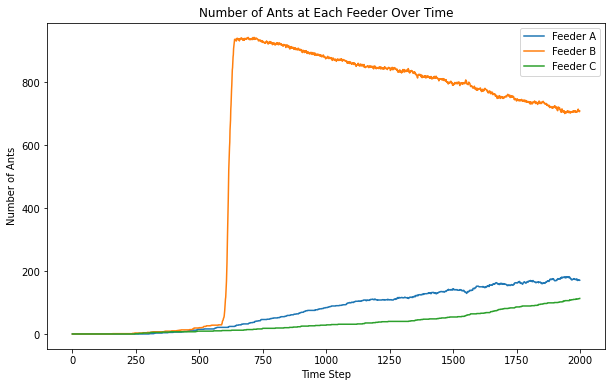

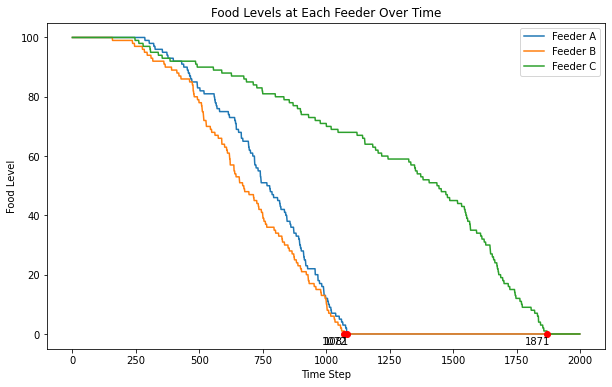

In [11]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Parameters
GRID_SIZE = 50
NEST = (25, 5)
FEEDER_A = (10, 40)
FEEDER_B = (40, 40)
FEEDER_C = (19, 49)
NUM_ANTS = 1000
INITIAL_FOOD_A = 100
INITIAL_FOOD_B = 100
INITIAL_FOOD_C = 100

ALPHA_A = 0.7950578278341167
ALPHA_B = 0.6509098761050796
ALPHA_C = 0.8685863531973065

BETA_A = 0.4618237385954602
BETA_B = 0.33385927607343113
BETA_C = 0.3452863887641166

LAMBDA_A = 0.007984898653161345
LAMBDA_B = 0.006887835173525471
LAMBDA_C = 0.00752665699204515

TIME_STEPS = 2000

class Ant:
    def __init__(self, name, position):
        self.name = name
        self.position = position
        self.carrying = False
        self.committed_to = None

    def move(self):
        # New position: ant can move one square in any direction
        new_position = (self.position[0] + random.choice([-1, 0, 1]), self.position[1] + random.choice([-1, 0, 1]))

        # Checking if the new position is within the grid
        if 0 <= new_position[0] < GRID_SIZE and 0 <= new_position[1] < GRID_SIZE:
            self.position = new_position

    def return_to_feeder(self):
        if self.committed_to:
            dx = np.sign(self.committed_to.position[0] - self.position[0])
            dy = np.sign(self.committed_to.position[1] - self.position[1])
            new_position = (self.position[0] + dx, self.position[1] + dy)

            # Checking if the new position is within the grid
            if 0 <= new_position[0] < GRID_SIZE and 0 <= new_position[1] < GRID_SIZE:
                self.position = new_position

    def pick_up_food(self, feeder):
        # Ant picks up food from the feeder if it's near it
        if self.is_near_feeder(feeder) and feeder.food > 0 and not self.carrying:
            feeder.food -= 1
            self.carrying = True

    def drop_food(self):
        # Ant drops off food at the nest if it's carrying food
        if self.position == NEST and self.carrying:
            self.carrying = False

    def is_near_feeder(self, feeder):
        # Checking if the ant is near the feeder
        return abs(self.position[0] - feeder.position[0]) <= 1 and abs(self.position[1] - feeder.position[1]) <= 3

    def discover_feeder(self, feeder):
        # Ant stumbles upon a feeder and decides whether to commit based on alpha
        if self.is_near_feeder(feeder) and random.random() < feeder.alpha:
            self.committed_to = feeder

    def recruit(self, ants, beta):
        # Ant recruits other ants to its committed feeder based on beta
        if self.committed_to:
            for ant in ants:
                if ant != self and ant.committed_to is None and random.random() < beta:
                    # Checking if the other ant is in the same or adjacent square
                    if max(abs(self.position[0] - ant.position[0]), abs(self.position[1] - ant.position[1])) <= 1:
                        ant.committed_to = self.committed_to

    def forget_feeder(self, lambda_):
        # Ant forgets about its committed feeder based on lambda
        if self.committed_to and random.random() < lambda_:
            self.committed_to = None

class Feeder:
    def __init__(self, food, position, alpha, beta, lambda_):
        self.food = food
        self.position = position
        self.alpha = alpha
        self.beta = beta
        self.lambda_ = lambda_

# Initializing the feeders
feeder_a = Feeder(INITIAL_FOOD_A, FEEDER_A, ALPHA_A, BETA_A, LAMBDA_A)
feeder_b = Feeder(INITIAL_FOOD_B, FEEDER_B, ALPHA_B, BETA_B, LAMBDA_B)
feeder_c = Feeder(INITIAL_FOOD_C, FEEDER_C, ALPHA_C, BETA_C, LAMBDA_C)

# Create ants at the nest
ants = [Ant(f'Ant {i}', NEST) for i in range(NUM_ANTS)]

# Number of ants at each feeder over time
ants_at_feeder_a = []
ants_at_feeder_b = []
ants_at_feeder_c = []

# Food levels at each feeder over time
food_at_feeder_a = []
food_at_feeder_b = []
food_at_feeder_c = []

for _ in range(TIME_STEPS):

    # Food levels at each feeder
    food_at_feeder_a.append(feeder_a.food)
    food_at_feeder_b.append(feeder_b.food)
    food_at_feeder_c.append(feeder_c.food)

    # Number of ants committed to each feeder
    ants_at_feeder_a.append(sum(1 for ant in ants if ant.committed_to == feeder_a))
    ants_at_feeder_b.append(sum(1 for ant in ants if ant.committed_to == feeder_b))
    ants_at_feeder_c.append(sum(1 for ant in ants if ant.committed_to == feeder_c))

    # Each ant moves, decides whether to commit to a feeder, eats, and possibly forgets about its feeder
    for ant in ants:
        ant.move()
        if ant.carrying:
            ant.drop_food()
            ant.return_to_feeder()
        else:
            if ant.is_near_feeder(feeder_a):
                ant.discover_feeder(feeder_a)
            elif ant.is_near_feeder(feeder_b):
                ant.discover_feeder(feeder_b)
            elif ant.is_near_feeder(feeder_c):
                ant.discover_feeder(feeder_c)
            ant.pick_up_food(ant.committed_to if ant.committed_to else random.choice([feeder_a, feeder_b, feeder_c]))
            ant.forget_feeder(ant.committed_to.lambda_ if ant.committed_to else 0)
            ant.recruit(ants, ant.committed_to.beta if ant.committed_to else 0)

# Ants committed to each feeder over time
plt.figure(figsize=(10, 6))
plt.plot(ants_at_feeder_a, label='Feeder A')
plt.plot(ants_at_feeder_b, label='Feeder B')
plt.plot(ants_at_feeder_c, label='Feeder C')
plt.xlabel('Time Step')
plt.ylabel('Number of Ants')
plt.title('Number of Ants at Each Feeder Over Time')
plt.legend()
plt.show()

# Time steps at which each feeder is depleted
time_to_depletion_a = next((i for i, x in enumerate(food_at_feeder_a) if x == 0), None)
time_to_depletion_b = next((i for i, x in enumerate(food_at_feeder_b) if x == 0), None)
time_to_depletion_c = next((i for i, x in enumerate(food_at_feeder_c) if x == 0), None)

# Food levels at each feeder over time
plt.figure(figsize=(10, 6))
plt.plot(food_at_feeder_a, label='Feeder A')
plt.plot(food_at_feeder_b, label='Feeder B')
plt.plot(food_at_feeder_c, label='Feeder C')

# Time stamps where the food levels are completely depleted
if time_to_depletion_a is not None:
    plt.plot(time_to_depletion_a, 0, 'ro')
    plt.annotate(str(time_to_depletion_a), (time_to_depletion_a, 0), textcoords="offset points", xytext=(-10,-10), ha='center')
if time_to_depletion_b is not None:
    plt.plot(time_to_depletion_b, 0, 'ro')
    plt.annotate(str(time_to_depletion_b), (time_to_depletion_b, 0), textcoords="offset points", xytext=(-10,-10), ha='center')
if time_to_depletion_c is not None:
    plt.plot(time_to_depletion_c, 0, 'ro')
    plt.annotate(str(time_to_depletion_c), (time_to_depletion_c, 0), textcoords="offset points", xytext=(-10,-10), ha='center')

plt.xlabel('Time Step')
plt.ylabel('Food Level')
plt.title('Food Levels at Each Feeder Over Time')
plt.legend()
plt.show()